In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, SVD, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
data.head()

,userId,wine,rate
0,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso,3
1,df904a46-c461-4233-9d44-6ac11a8bbddc,Astrale,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3
3,bc79b0e3-064d-4240-86de-e86499f577e8,3/11 Syrah and blend #4,3
4,5ccd8030-047b-432c-a630-d784ab415756,Valpolicella Ripasso Classico Superiore Pojega,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Biased','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Biased, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Svd (SVD):
    def __init__(self, n_factors, n_epochs, biased, lr_all, reg_all, verbose):#, bsl_options={}):
       SVD.__init__(self, 
                    n_factors= n_factors, n_epochs = n_epochs,
                      biased= biased, lr_all= lr_all, 
                      reg_all= reg_all, verbose = verbose)#, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            SVD.fit(self, trainset_fold)
            train_prediction = SVD.test(self, trainset_fold.build_testset())
            prediction = SVD.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = SVD.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## SVD and SGD

The minimization is performed by a very straightforward stochastic gradient descent:
* note You can choose to use an unbiased version of this algorithm
* verbose – If True, prints the current epoch. Default is False.

In [4]:
svd = Svd(n_factors= 100, n_epochs= 60, biased= True, lr_all= 0.05, reg_all=0.02 , verbose=False)

svd.create_reader(data)
predictions = svd.fit()
#acc
metrics = svd.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'Singular Value Decomposition'
# metrics['Metric'] = 'Cosine'
# metrics['Optimizer'] = 'SGD'
metrics['Biased'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.1662
RMSE: 1.2357
RMSE: 0.0848
RMSE: 1.3385
RMSE: 0.1547
RMSE: 1.2873
RMSE: 0.1531
RMSE: 1.2660
RMSE: 0.1108
RMSE: 1.2674
###############################################
The Results are: 

Average RMSE on Training Set: 0.13393933015531237
Average RMSE on Test Set: 1.2789725964838219
RMSE: 1.2353
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.2352831160259123
RMSE: 1.2353
MAE:  1.0060
MSE: 1.5259
Precision: 0.10
Recall: 0.08
the acc is 28.80


/tmp/ipykernel_21784/3511808179.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [5]:
svd2 = Svd(n_factors= 100, n_epochs= 60, biased= False, lr_all= 0.05, reg_all=0.02 , verbose=False)

svd2.create_reader(data)
predictions = svd2.fit()
#acc
metrics = svd2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'Singular Value Decomposition'
# metrics['Metric'] = 'Cosine'
# metrics['Optimizer'] = 'SGD'
metrics['Biased'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

RMSE: 0.1111
RMSE: 1.4476
RMSE: 0.1498
RMSE: 1.5194
RMSE: 0.1574
RMSE: 1.5127
RMSE: 0.1449
RMSE: 1.6690
RMSE: 0.1130
RMSE: 1.4532
###############################################
The Results are: 

Average RMSE on Training Set: 0.13522803020474433
Average RMSE on Test Set: 1.520397986493292
RMSE: 1.3465
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.3464871056501768
RMSE: 1.3465
MAE:  0.9455
MSE: 1.8130
Precision: 0.05
Recall: 0.05
the acc is 41.88


/tmp/ipykernel_21784/4045968382.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_21784/4045968382.py:16: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [6]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Biased,RMSE,MAE,MSE,Precision,Recall,Accuracy
0,1,Singular Value Decomposition,True,1.235283,1.006018,1.525924,0.095866,0.075969,28.795812
1,2,Singular Value Decomposition,False,1.346487,0.945550,1.813028,0.048193,0.048193,41.884817


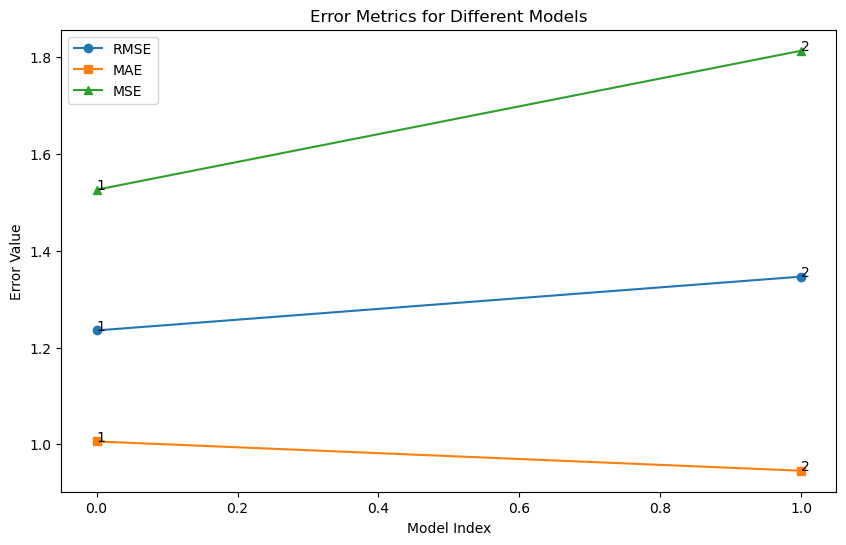

In [7]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

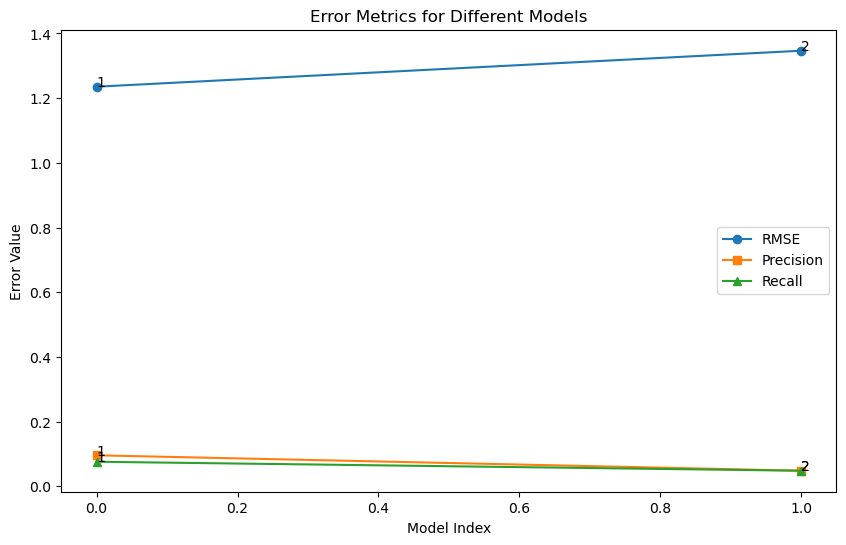

In [8]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

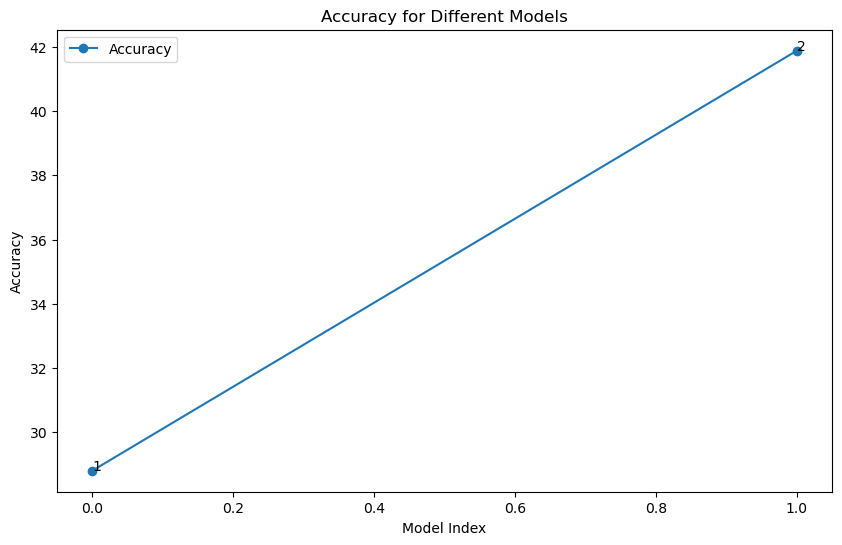

In [9]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [10]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = svd.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Pommard
2. Item ID: Fleurie Grand Pre
3. Item ID: Les Pierrelles Crozes-Hermitage
4. Item ID: Valle de Casablanca Sauvignon
5. Item ID: Pinot gris


In [11]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = svd.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 9a3cc655-c88e-4c1b-95e2-add7579ff4c2
2. User ID: d48fd3bd-06e9-4368-97b9-aae545388325


In [12]:
#get the KnnWithMeans for a user from the model
svd.get_neighbors_uid(user_id=5)

['36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 '83128cf9-f07f-4de1-97cf-cbde8d38bc3c',
 'ce15f400-8bb8-4f99-9a8f-d8f4408641fe',
 'e9a40b1d-e044-4cad-90ff-a1e62a37f999',
 '5ccd8030-047b-432c-a630-d784ab415756',
 '7c790e8b-b289-4190-a624-83db79de07af',
 '9a3cc655-c88e-4c1b-95e2-add7579ff4c2',
 '3d88fe74-6881-42bd-bb97-d67f2db649d7',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 'ecc462e1-5041-43ca-94c3-c2bfc9b3215e']

In [13]:
#get the KnnWithMeans for an item from the model
svd.get_neighbors_iid(item_id=20)

['Malbec (High Mountain Vines)',
 'Kaselar Dominikanerberg',
 'Vigna Piaggia Brunello di Montalcino',
 'Vitovska acciaio',
 'Grauburgunder Muschelkalk',
 'Dark Horse Shiraz',
 'Chianti classico',
 'Brachetto Piemonte',
 'Pignolo',
 'Dogliani']

In [14]:
svd.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(svd.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 0 with sim 0.200000000000000
And the baseline estimate is: 2.513802093212315

#####

Note: If the baseline is 2.911475409836066 then the value is a default value, Otherwise not


In [15]:
df_pred = svd.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Guado al Tasso,4.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",80,1,1.055738
1,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Pommard,5.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",16,0,2.055738
2,5ccd8030-047b-432c-a630-d784ab415756,Weissburgunder Trocken,2.0,1.000000,{'was_impossible': False},52,1,1.000000
3,441ac739-42f8-48d2-9526-fdedf2d4852f,Vitovska acciaio,2.0,1.000000,{'was_impossible': False},0,6,1.000000
4,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Etna Bianco,3.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",80,1,0.055738
5,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Fumin la griffe,3.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",19,0,0.055738
6,5ccd8030-047b-432c-a630-d784ab415756,Grauer Burgunder Muschelkalk,4.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",52,1,1.055738
7,df904a46-c461-4233-9d44-6ac11a8bbddc,Angiolo Puccini Organic Rosso Toscana,4.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",8,0,1.055738
8,a94874d2-6af9-4651-a1d3-036ed714f2cb,pelaverga,2.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",2,0,0.944262
9,bc79b0e3-064d-4240-86de-e86499f577e8,3/18 大陸白 1 Le Chene Marchand,3.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",24,0,0.055738


* best predictions

In [16]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
190,c30006c8-a677-4c8f-9c52-c8f00b48fea4,ATMA,1.0,1.0,{'was_impossible': False},4,2,0.0
166,22c5c1cb-88fd-4870-a911-846516978ed4,Neuburger 2019,1.0,1.0,{'was_impossible': False},2,6,0.0
165,776b5af7-bb8a-484a-bddb-dadf5dab4621,Weissburgunder Kallstadter Steinacker,1.0,1.0,{'was_impossible': False},3,2,0.0
43,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Pinot bianco,1.0,1.0,{'was_impossible': False},4,1,0.0
162,bf82194f-6108-4524-9cef-69c0231ac74b,Nespolino Rubicone Sangiovese - Merlot,1.0,1.0,{'was_impossible': False},1,3,0.0
47,7ed7fb0c-884d-46bf-a14a-205474a0949d,Reserve Merlot,1.0,1.0,{'was_impossible': False},3,3,0.0
50,4a3e010a-0761-48d4-90c1-b2905e0b7b4a,Moscata D'Asti Casaniere,1.0,1.0,{'was_impossible': False},3,7,0.0
51,5ccd8030-047b-432c-a630-d784ab415756,Passo alle Tremiti Rosato,1.0,1.0,{'was_impossible': False},52,2,0.0
54,c26b57e2-bb71-43ca-b5bd-361867658d42,The Society's Exhibition Shiraz,1.0,1.0,{'was_impossible': False},2,2,0.0
152,83128cf9-f07f-4de1-97cf-cbde8d38bc3c,Rubicon,1.0,1.0,{'was_impossible': False},5,2,0.0


* worst predictions

In [17]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
167,3da6eec4-bd99-4370-be23-676baf750f19,Rascal,5.0,2.944262,"{'was_impossible': True, 'reason': 'User and i...",2,1,2.055738
175,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Brachetto Piemonte,4.0,1.000000,{'was_impossible': False},6,3,3.000000
90,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Nebbiolo d'Alba DOC Spumante Cuvée 970 Brut Rosé,4.0,1.000000,{'was_impossible': False},40,3,3.000000
148,cabb87a0-6498-438a-beb7-676f72bddd09,Sauvignon Blanc,4.0,1.000000,{'was_impossible': False},6,4,3.000000
94,838e0d9d-27e9-4f89-9eab-ba2c2f412759,Vermentino,4.0,1.000000,{'was_impossible': False},5,0,3.000000
118,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Sauvignon,4.0,1.000000,{'was_impossible': False},6,2,3.000000
21,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Ormeasco di Pornassio,5.0,1.000000,{'was_impossible': False},5,0,4.000000
56,a3b393ad-38d5-4c5a-b814-5fec18a1fa9d,Opera Viva,5.0,1.000000,{'was_impossible': False},3,2,4.000000
185,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Metodo Classico Pas Dosé,5.0,1.000000,{'was_impossible': False},40,2,4.000000
122,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Cabernet Sauvignon,5.0,1.000000,{'was_impossible': False},40,1,4.000000
